In [3]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import matplotlib.pyplot as plt

In [4]:
print(tf.__version__)

2.8.2


### Download the flowers dataset

This tutorial uses a dataset of several thousand photos of flowers. The flowers dataset contains five sub-directories, one per class:

```
flowers_photos/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [5]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)

228827136/228813984 [==============================] - 2s 0us/step


In [6]:
data_dir

PosixPath('/root/.keras/datasets/flower_photos')

In [9]:
!ls -ltrh /root/.keras/datasets/flower_photos/

total 604K
-rw-r----- 1 270850 5000 409K Feb  9  2016 LICENSE.txt
drwx------ 2 270850 5000  36K Feb 10  2016 tulips
drwx------ 2 270850 5000  36K Feb 10  2016 sunflowers
drwx------ 2 270850 5000  36K Feb 10  2016 roses
drwx------ 2 270850 5000  44K Feb 10  2016 dandelion
drwx------ 2 270850 5000  36K Feb 10  2016 daisy


After downloading (218MB), you should now have a copy of the flower photos available. There are 3,670 total images:

In [10]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Each directory contains images of that type of flower. Here are some roses:

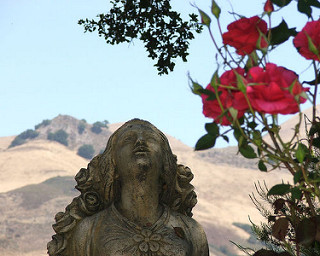

In [11]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

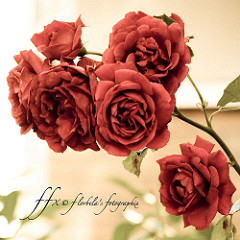

In [12]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

Now it's time to extract these image files using TensorFlow `tf.data` API.\
In this tutorial we will use two different APIs (one low-level API and one High-level API to extract the images.)


## Extracting Images with Low-Level `tf.data` API

In [13]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)

In [14]:
list_ds = list_ds.shuffle(buffer_size=1000, reshuffle_each_iteration=False)

In [15]:
for path in list_ds.take(10):
    print(path)

tf.Tensor(b'/root/.keras/datasets/flower_photos/dandelion/14048849371_ec9dbafaeb_m.jpg', shape=(), dtype=string)
tf.Tensor(b'/root/.keras/datasets/flower_photos/dandelion/15005530987_e13b328047_n.jpg', shape=(), dtype=string)
tf.Tensor(b'/root/.keras/datasets/flower_photos/dandelion/13916196427_50a611008f.jpg', shape=(), dtype=string)
tf.Tensor(b'/root/.keras/datasets/flower_photos/dandelion/14058811536_f29cd7bd58_n.jpg', shape=(), dtype=string)
tf.Tensor(b'/root/.keras/datasets/flower_photos/daisy/9244082319_b1f7e2d8b0_n.jpg', shape=(), dtype=string)
tf.Tensor(b'/root/.keras/datasets/flower_photos/dandelion/17280886635_e384d91300_n.jpg', shape=(), dtype=string)
tf.Tensor(b'/root/.keras/datasets/flower_photos/daisy/5883162120_dc7274af76_n.jpg', shape=(), dtype=string)
tf.Tensor(b'/root/.keras/datasets/flower_photos/daisy/15207766_fc2f1d692c_n.jpg', shape=(), dtype=string)
tf.Tensor(b'/root/.keras/datasets/flower_photos/dandelion/18803577858_fd0036e1f5_m.jpg', shape=(), dtype=string)
tf

In [16]:
# Reads an image from a file, decodes it into a dense tensor, and resizes it
# to a fixed shape.
def parse_image(filename):
  parts = tf.strings.split(filename, os.sep)
  label = parts[-2]

  image = tf.io.read_file(filename)
  image = tf.io.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [128, 128])
  return image, label

Test It!

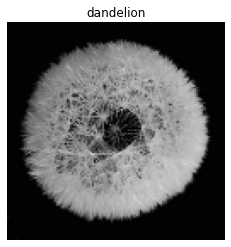

In [17]:
file_path = next(iter(list_ds))
image, label = parse_image(file_path)

def show(image, label):
  plt.figure()
  plt.imshow(image)
  plt.title(label.numpy().decode('utf-8'))
  plt.axis('off')

show(image, label)

In [18]:
label

<tf.Tensor: shape=(), dtype=string, numpy=b'dandelion'>

In [19]:
image

<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
array([[[0.01176471, 0.01176471, 0.01176471],
        [0.01176471, 0.01176471, 0.01176471],
        [0.01176471, 0.01176471, 0.01176471],
        ...,
        [0.01176471, 0.01176471, 0.01176471],
        [0.01176471, 0.01176471, 0.01176471],
        [0.01176471, 0.01176471, 0.01176471]],

       [[0.01176471, 0.01176471, 0.01176471],
        [0.01176471, 0.01176471, 0.01176471],
        [0.01176471, 0.01176471, 0.01176471],
        ...,
        [0.01176471, 0.01176471, 0.01176471],
        [0.01176471, 0.01176471, 0.01176471],
        [0.01176471, 0.01176471, 0.01176471]],

       [[0.01176471, 0.01176471, 0.01176471],
        [0.01176471, 0.01176471, 0.01176471],
        [0.01176471, 0.01176471, 0.01176471],
        ...,
        [0.01176471, 0.01176471, 0.01176471],
        [0.01176471, 0.01176471, 0.01176471],
        [0.01176471, 0.01176471, 0.01176471]],

       ...,

       [[0.00784314, 0.00784314, 0.00784314],
        [0.01

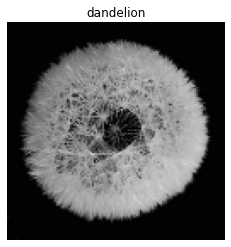

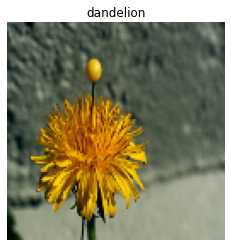

In [20]:
images_ds = list_ds.map((parse_image))

for image, label in images_ds.take(2):
  show(image, label)

In [21]:
images_ds.element_spec

(TensorSpec(shape=(128, 128, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.string, name=None))

In [22]:
CLASS_NAMES = [b'tulips', b'sunflowers', b'roses', b'dandelion', b'daisy']
def parse_image_encode_labels(filename):
  parts = tf.strings.split(filename, os.sep)
  label = tf.argmax(tf.cast(parts[-2] == CLASS_NAMES, tf.int32))
  image = tf.io.read_file(filename)
  image = tf.io.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [128, 128])
  return image, label

In [23]:
images_labels_ds = list_ds.map(parse_image_encode_labels)

In [24]:
images_labels_ds.element_spec

(TensorSpec(shape=(128, 128, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [25]:
for image, label in images_labels_ds.take(2):
    print(label)

tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)


## Train-Validation Split

In [27]:
ds_size = 3670
val_split = 0.2
train_size = int(ds_size * (1 - val_split))
#images_labels_ds = images_labels_ds.shuffle(buffer_size=4000, reshuffle_each_iteration=False)
ds_train = images_labels_ds.take(train_size)
ds_val = images_labels_ds.skip(train_size)

In [28]:
ds_train = ds_train.batch(32)
ds_val = ds_val.batch(32)

In [29]:
for image_batch, labels_batch in ds_train.take(1):
  print(image_batch.shape)
  print(labels_batch.shape)

(32, 128, 128, 3)
(32,)


## High-Level API for Extracting Image Data

Define some parameters for the loader:

In [30]:
batch_size = 32
img_height = 180
img_width = 180

In [31]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [32]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


You can find the class names in the `class_names` attribute on these datasets.

In [33]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


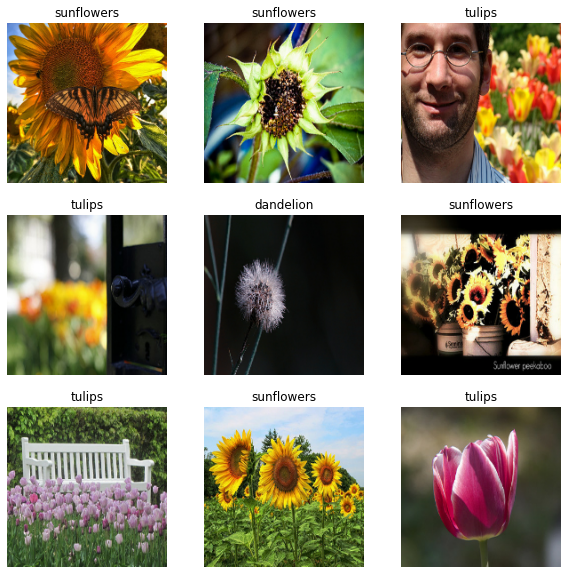

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [34]:
for image_batch, labels_batch in train_ds.take(1):
  print(image_batch.shape)
  print(labels_batch.shape)

(32, 180, 180, 3)
(32,)


## Apply Transformations
As we discussed earlier, we can apply a transformation function to the elements of a TensorFlow dataset by using `.map` method.

### Standardize the data
The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

#### Using Keras Layers
Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [37]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [38]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.96902645


#### Using Python Functions

In [39]:
def normalize_images(image, label):
    normalized_image = image / 255.
    return normalized_image, label

In [40]:
normalized_ds = train_ds.map(normalize_images)
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.996387


## Boosting Performance
These are two important methods you should use when loading data to increase the speed of loading datasets:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance) guide.

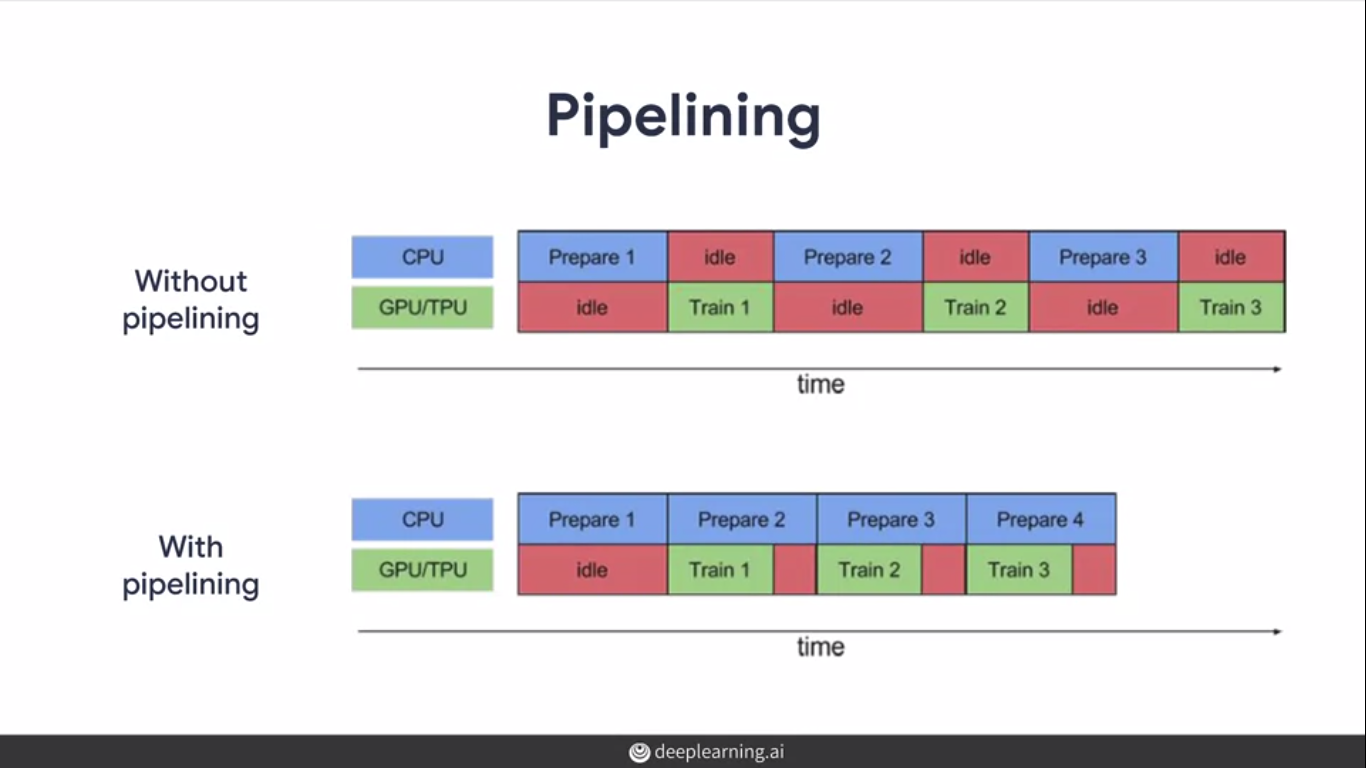

In [41]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Train a model

For completeness, you will show how to train a simple model using the datasets you have just prepared.

In [42]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [43]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 118s 1s/step - loss: 12.1249 - accuracy: 0.2503 - val_loss: 1.5700 - val_accuracy: 0.2902
Epoch 2/3
92/92 [==============================] - 113s 1s/step - loss: 1.4089 - accuracy: 0.4292 - val_loss: 1.5205 - val_accuracy: 0.3501
Epoch 3/3
92/92 [==============================] - 105s 1s/step - loss: 1.0920 - accuracy: 0.5800 - val_loss: 1.5886 - val_accuracy: 0.3556
